In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("D:/Datasets/Kaggle/Elo Merchant Category Recommendation")

import datetime

In [4]:
train_df = pd.read_csv("train.csv", parse_dates = ["first_active_month"])
test_df = pd.read_csv("test.csv", parse_dates = ["first_active_month"])

Looking for the `unique` and `null counts` of the various categories

In [5]:
# Unique labels and Null value counts
info_df = pd.DataFrame({"Unique": train_df.nunique(), "Null_count": train_df.isnull().sum()})
info_df

,Unique,Null_count
first_active_month,75,0
card_id,201917,0
feature_1,5,0
feature_2,3,0
feature_3,2,0
target,197110,0


In [6]:
# printing all the unique labels
print("Feature 1 = ", train_df.feature_1.unique())
print("Feature 2 = ", train_df.feature_2.unique())
print("Feature 3 = ", train_df.feature_3.unique())

Feature 1 =  [5 4 2 1 3]
Feature 2 =  [2 1 3]
Feature 3 =  [1 0]


In [7]:
# longevity
train_df["time"] = (datetime.date(2018, 12, 1) - train_df["first_active_month"].dt.date).astype("int64")
test_df["time"] = (datetime.date(2018, 12, 1) - test_df["first_active_month"].dt.date).astype("int64")

In [8]:
# correlation between target and time
train_df["target"].corr(train_df["time"])

-0.05045316646659414

In [9]:
train_df["feature_1"].value_counts()

3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64

In [10]:
train_df["feature_2"].value_counts()

1    89242
2    74839
3    37836
Name: feature_2, dtype: int64

In [11]:
train_df["feature_3"].value_counts()

1    114198
0     87719
Name: feature_3, dtype: int64

In [12]:
# one-hot encoding
train_df = pd.get_dummies(train_df, columns = ["feature_1", "feature_2"])
test_df = pd.get_dummies(test_df, columns = ["feature_1", "feature_2"])

In [13]:
train_df.head()

,first_active_month,card_id,feature_3,target,time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06-01,C_ID_92a2005557,1,-0.820283,47347200000000000,0,0,0,0,1,0,1,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,60393600000000000,0,0,0,1,0,1,0,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,73612800000000000,0,1,0,0,0,0,1,0
3,2017-09-01,C_ID_186d6a6901,0,0.142495,39398400000000000,0,0,0,1,0,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159749,34128000000000000,1,0,0,0,0,0,0,1


### target variable is calculated after 2 months of train and evaluation period.

In [14]:
hist_trans_df = pd.read_csv("historical_transactions.csv")

In [15]:
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


### Historical Transactions -
1. month_lag - month lag to reference date
2. authorised_flag - "Y" is approved and "N" is denied
3. installments - number of installments of purchase

In [17]:
hist_trans_info_df = pd.DataFrame({"Unique": hist_trans_df.nunique(), "Null": hist_trans_df.isnull().sum()})
hist_trans_info_df

,Unique,Null
authorized_flag,2,0
card_id,325540,0
city_id,308,0
category_1,2,0
installments,15,0
category_3,3,178159
merchant_category_id,327,0
merchant_id,326311,138481
month_lag,14,0
purchase_amount,215014,0


In [18]:
print("Authorized Flag => ", hist_trans_df.authorized_flag.unique())
print("Category 1 => ", hist_trans_df.category_1.unique())
print("Category 2 => ", hist_trans_df.category_2.unique())
print("Category 3 => ", hist_trans_df.category_3.unique())
print("Installments => ", hist_trans_df.installments.unique())

Authorized Flag =>  ['Y' 'N']
Category 1 =>  ['N' 'Y']
Category 2 =>  [ 1. nan  3.  5.  2.  4.]
Category 3 =>  ['A' 'B' 'C' nan]
Installments =>  [  0   1   5   3   4   2  -1  10   6  12   8   7   9  11 999]


In [19]:
hist_trans_df["authorized_flag"] = hist_trans_df["authorized_flag"].map({"Y":0, "N":1})

In [20]:
hist_trans_df["category_1"] = hist_trans_df["category_1"].map({"Y": 0, "N": 1})

In [21]:
hist_trans_df["category_3"] = hist_trans_df["category_3"].map({"A": 0, "B": 1, "C": 2})

### The category 2 and category 3 have nan values. To replace these values, we will use mode of these columns.

In [22]:
hist_trans_df.category_2.value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [23]:
hist_trans_df.category_3.value_counts()

0.0    15411747
1.0    11677522
2.0     1844933
Name: category_3, dtype: int64

In [24]:
values  = {"category_2": 1, "category_3": 0}
hist_trans_df = hist_trans_df.fillna(value = values)

In [28]:
# checking if imputation have happened correctly or not

print("Authorized Flag => ", hist_trans_df.authorized_flag.unique())
print("Category 1 => ", hist_trans_df.category_1.unique())
print("Category 2 => ", hist_trans_df.category_2.unique())
print("Category 3 => ", hist_trans_df.category_3.unique())
print("Installments => ", hist_trans_df.installments.unique())

Authorized Flag =>  [0 1]
Category 1 =>  [1 0]
Category 2 =>  [1. 3. 5. 2. 4.]
Category 3 =>  [0. 1. 2.]
Installments =>  [  0   1   5   3   4   2  -1  10   6  12   8   7   9  11 999]


In [29]:
hist_trans_df = pd.get_dummies(hist_trans_df, columns = ["category_2", "category_3"])
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0.0,category_3_1.0,category_3_2.0
0,0,C_ID_4e6213e9bc,88,1,0,80,M_ID_e020e9b302,-8,-0.703331,1.498405e+09,16,37,1,0,0,0,0,1,0,0
1,0,C_ID_4e6213e9bc,88,1,0,367,M_ID_86ec983688,-7,-0.733128,1.500121e+09,16,16,1,0,0,0,0,1,0,0
2,0,C_ID_4e6213e9bc,88,1,0,80,M_ID_979ed661fc,-6,-0.720386,1.502316e+09,16,37,1,0,0,0,0,1,0,0
3,0,C_ID_4e6213e9bc,88,1,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,1.504347e+09,16,34,1,0,0,0,0,1,0,0
4,0,C_ID_4e6213e9bc,88,1,0,80,M_ID_e020e9b302,-11,-0.722865,1.489108e+09,16,37,1,0,0,0,0,1,0,0


### Aggregating Both transactions

In [30]:
def aggregate_transactions(trans, prefix):
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        "authorized_flag": ["sum", "mean"],
        "category_1": ["mean"],
        "category_2_1.0": ["mean"],
        "category_2_2.0": ["mean"],
        "category_2_3.0": ["mean"],
        "category_2_4.0": ["mean"],
        "category_2_5.0": ["mean"],
        "category_3_0.0": ["mean"],
        "category_3_1.0": ["mean"],
        "category_3_2.0": ["mean"],
        "installments": ["sum", "mean", "max", "min", "std"],
        "purchase_amount": ["sum", "mean", "max", "min", "std"],
        "purchase_date": [np.ptp], # range of values = "peak to peak"
        "month_lag": ["min", "max"]
    }
    
    agg_trans = trans.groupby(["card_id"]).agg(agg_func) # dataframe.groupby(["column_name"]).agg(function_name)
                                                         # the function -  dictionary with {col_name : list of functions}
    agg_trans.columns = [prefix + "_".join(col).strip() for col in agg_trans.columns.values]
    # strip removes the leading and trailing characters mentioned. If no argument is passed, whitespaces are removed
    
    agg_trans.reset_index(inplace = True)
    df = trans.groupby("card_id").size().reset_index(name = "{}transaction_count".format(prefix))
    agg_trans = pd.merge(df, agg_trans, on = "card_id", how = "left")
    
    return agg_trans

In [31]:
# Invoking the garbage collector manually during the execution of a program can be a good idea
# on how to handle memory being consumed by reference cycles.

import gc
merch_hist = aggregate_transactions(hist_trans_df, prefix = "hist_")
del hist_trans_df
gc.collect()
train_df = pd.merge(train_df, merch_hist, on = "card_id", how = "left")
test_df = pd.merge(test_df, merch_hist, on = "card_id", how = "left")
del merch_hist
gc.collect()
train_df.head()

,first_active_month,card_id,feature_3,target,time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,...,hist_installments_min,hist_installments_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,1,-0.820283,47347200000000000,0,0,0,0,1,...,0,0.123314,-165.968739,-0.638341,2.258395,-0.739395,0.212139,0.020978,-8,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,60393600000000000,0,0,0,1,0,...,-1,1.510777,-210.006336,-0.600018,4.630299,-0.742400,0.384967,0.033718,-12,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,73612800000000000,0,1,0,0,0,...,0,0.000000,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0.035636,-13,0
3,2017-09-01,C_ID_186d6a6901,0,0.142495,39398400000000000,0,0,0,1,0,...,-1,0.588974,-49.491364,-0.642745,1.445596,-0.740897,0.261624,0.013375,-5,0
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159749,34128000000000000,1,0,0,0,0,...,1,1.896862,-48.687656,-0.366073,7.193041,-0.746156,1.352094,0.009406,-3,0


In [32]:
target = train_df["target"]
drops = ["card_id", "first_active_month", "target"]
use_cols = [c for c in train_df.columns if c not in drops]
features = list(train_df[use_cols].columns)
train_df[features].head()

,feature_3,time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,hist_installments_min,hist_installments_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,1,47347200000000000,0,0,0,0,1,0,1,0,...,0,0.123314,-165.968739,-0.638341,2.258395,-0.739395,0.212139,0.020978,-8,0
1,0,60393600000000000,0,0,0,1,0,1,0,0,...,-1,1.510777,-210.006336,-0.600018,4.630299,-0.742400,0.384967,0.033718,-12,0
2,0,73612800000000000,0,1,0,0,0,0,1,0,...,0,0.000000,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0.035636,-13,0
3,0,39398400000000000,0,0,0,1,0,0,0,1,...,-1,0.588974,-49.491364,-0.642745,1.445596,-0.740897,0.261624,0.013375,-5,0
4,0,34128000000000000,1,0,0,0,0,0,0,1,...,1,1.896862,-48.687656,-0.366073,7.193041,-0.746156,1.352094,0.009406,-3,0


In [33]:
print(train_df.shape)
print(test_df.shape)

(201917, 38)
(123623, 37)


In [34]:
# param is a dict defining parameters for LGBM
param = {"num_leaves": 50,
        "min_leaf_in_leaf": 30,
        "objective": "regression",
        "max_depth": -1,
        "learning_rate": 0.005,
        "boosting": "gbdt",
        "feature_fraction": 0.9, 
        "bagging_freq": 1,
        "bagging_fraction": 0.9, 
        "bagging_seed": 11,
        "metric": "rmse", 
        "lambda_l1": 0.1, 
        "verbosity": -1}

folds = KFold(n_splits = 5, shuffle = True, random_state = 15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [35]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("-")
    print("Fold {}".format(fold_+1))
    trn_data = lgbm.Dataset(train_df.iloc[trn_idx][features], label = target.iloc[trn_idx])
    val_data = lgbm.Dataset(train_df.iloc[trn_idx][features], label = target.iloc[trn_idx])
    num_rounds = 1000
    clf = lgbm.train(param, trn_data, num_rounds, valid_sets = [trn_data, val_data], verbose_eval = 100, \
                    early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iterations = clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iterations = clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.76895	valid_1's rmse: 3.76895
[200]	training's rmse: 3.72019	valid_1's rmse: 3.72019
[300]	training's rmse: 3.68308	valid_1's rmse: 3.68308
[400]	training's rmse: 3.6529	valid_1's rmse: 3.6529
[500]	training's rmse: 3.62661	valid_1's rmse: 3.62661
[600]	training's rmse: 3.6048	valid_1's rmse: 3.6048
[700]	training's rmse: 3.58662	valid_1's rmse: 3.58662
[800]	training's rmse: 3.57125	valid_1's rmse: 3.57125
[900]	training's rmse: 3.55771	valid_1's rmse: 3.55771
[1000]	training's rmse: 3.54591	valid_1's rmse: 3.54591
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 3.54591	valid_1's rmse: 3.54591
-
Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78707	valid_1's rmse: 3.78707
[200]	training's rmse: 3.73601	valid_1's rmse: 3.73601
[300]	training's rmse: 3.69838	valid_1's rmse: 3.69838
[400]	training's rmse: 3.66823	valid_1's

In [36]:
from sklearn.metrics import mean_squared_error
val_score = np.sqrt(mean_squared_error(target, oof))
val_score

3.7628981516376068

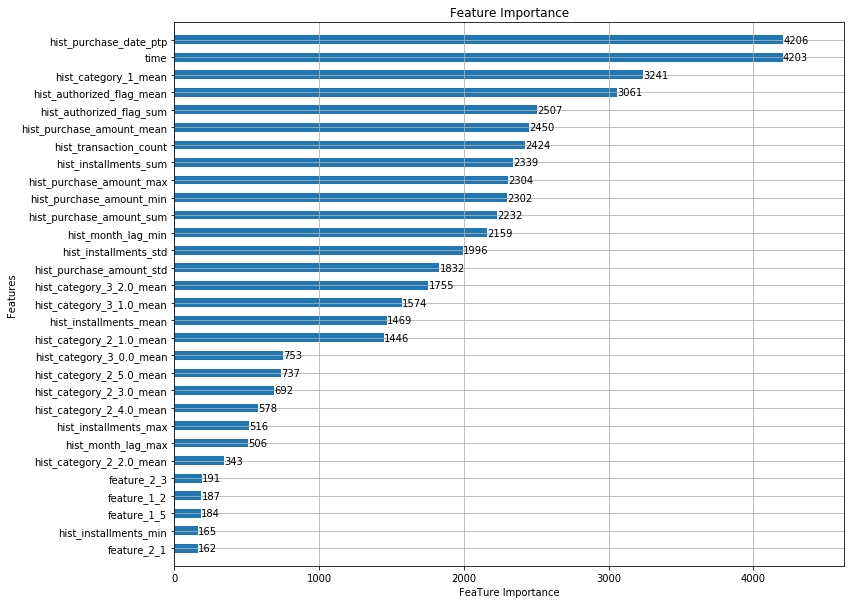

In [59]:
fig, ax = plt.subplots(figsize = (12, 10))
lgbm.plot_importance(clf, max_num_features = 30, height = 0.5, ax = ax, titl  e = "Feature Importance", \
                   xlabel = "FeaTure Importance", ylabel = "Features")
plt.show()

In [64]:
df_sub = pd.DataFrame({"card_id":test_df["card_id"].values})
df_sub["target"] = predictions
df_sub  = df_sub.set_index(df_sub["card_id"])
df_sub = df_sub.drop(columns = ["card_id"])

In [65]:
#df_sub.to_csv("elo_.csv")

---